# Implementasi Mini-batch Gradient Descent

Dibuat oleh: <br>
13521071 - Margaretha Olivia Haryono <br>
13521084 - Austin Gabriel Pardosi <br>
13521108 - Michael Leon Putra Widhi <br>
13521172 - Nathan Tenka

## Pengantar Singkat

### *Gradient Descent*
*Gradient Descent* adalah metode optimisasi yang digunakan untuk menemukan nilai minimum dari sebuah fungsi dengan iteratif mengikuti arah gradien turunan parsialnya. Dalam setiap iterasi, parameter diperbarui dengan langkah yang sebanding dengan negatif gradien pada titik tersebut, dikalikan dengan tingkat pembelajaran yang merupakan faktor penting dalam kecepatan konvergensi algoritma. Variasi dari *Gradient Descent* seperti *Stochastic Gradient Descent* (SGD) dan *Mini-batch Gradient Descent* memungkinkan pengoptimalan model pada dataset besar dengan lebih efisien, dengan SGD melakukan pembaruan parameter secara acak dan Mini-batch GD membagi dataset menjadi batch-batch kecil. Meskipun efektif, pemilihan tingkat pembelajaran yang tepat dan inisialisasi parameter yang bijaksana tetap penting untuk keberhasilan konvergensi algoritma ini.

### *Mini-Batch Gradient Descent*
*Mini-batch Gradient Descent* adalah varian dari metode optimisasi *Gradient Descent* yang membagi dataset menjadi batch-batch kecil untuk menghitung gradien secara efisien. Setiap iterasi melibatkan pembaruan parameter dengan mempertimbangkan rata-rata gradien dari satu batch data, yang membantu mempercepat konvergensi algoritma dan mengurangi kebutuhan akan memori yang besar. Dengan memanfaatkan pendekatan ini, *Mini-batch Gradient Descent* memungkinkan pembelajaran model yang efisien pada dataset besar tanpa kehilangan akurasi, sehingga menjadi pilihan yang populer dalam pembelajaran mesin dan *deep learning*.

### Mengapa *Mini-Batch Gradient Descent* ?

![Mini-Batch Gradient Descent](https://statusneo.com/wp-content/uploads/2023/09/Credit-Analytics-Vidya.jpg)

*Mini-batch Gradient Descent* digunakan untuk mempercepat konvergensi algoritma optimisasi dengan membagi dataset menjadi *batch-batch* kecil, yang memungkinkan perhitungan gradien secara efisien. Pendekatan ini mengurangi beban memori dan mempercepat proses pembelajaran, menjadikannya pilihan yang populer dalam pembelajaran mesin dan deep learning. Dengan mengambil langkah yang dihitung berdasarkan rata-rata gradien dari batch data, *Mini-batch Gradient Descent* memungkinkan optimisasi model pada dataset besar tanpa kehilangan akurasi, menjadikannya pendekatan yang efektif dalam mengatasi masalah skala besar.

## Hasil Implementasi

### Impor modul eksternal
Modul yang berkaitan dengan hasil implementasi

In [1]:
import json
import time
import math
import pickle
import random
import pandas as pd
import numpy as np
from typing import TypedDict
from graphviz import Digraph
from IPython.display import display, Image

Modul yang berkaitan dengan Scikit-learn

In [2]:
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report

### Fungsi Aktivasi
Pada bagian ini terdapat beberapa fungsi untuk melakukan nilai hasil substitusi pada fungsi aktivasi. Berbeda dengan bagian sebelumnya, fungsi yang dibangun telah memungkinkan untuk melakukan kalkulasi nilai turunan dari fungsi aktivasi.

In [3]:
import numpy as np

# Fungsi aktivasi reLU
def relu(x, derivative=False):
    x = np.array(x, dtype=float)
    if derivative:
        return (x > 0).astype(float)
    return np.maximum(0, x)

# Fungsi aktivasi sigmoid
def sigmoid(x, derivative=False):
    x = np.array(x, dtype=float)
    if derivative:
        sig = 1 / (1 + np.exp(-x))
        return sig * (1 - sig)
    return 1 / (1 + np.exp(-x))

# Fungsi aktivasi linear
def linear(x, derivative=False):
    x = np.array(x, dtype=float)
    if derivative:
        return np.ones_like(x)
    return x

# Fungsi aktivasi softmax
def softmax(x, derivative=False, y_true=None):
    x = np.atleast_2d(np.array(x, dtype=float))
    exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
    probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
    
    if derivative:
        if y_true is None:
            raise ValueError("y_true must be provided for the derivative calculation.")
        y_true = np.atleast_2d(y_true)
        return probabilities - y_true
    
    return probabilities

# Mengambil nilai fungsi aktivasi berdasarkan masukan pengguna
def get_activation_function(function_name):
    if function_name == "linear":
        return linear
    elif function_name == "relu":
        return relu
    elif function_name == "sigmoid":
        return sigmoid
    elif function_name == "softmax":
        return softmax
    else:
        raise Exception("Activation function not found.")

### Layer
Kelas Layer merepresentasikan layer yang digunakan sebagai bagian dari Dense Layer. Kelas ini juga memeiliki sebuah metode tambahan untuk melakukan pengacakan bobot awal sehingga dihasilkan bobot yang uniform untuk setiap neuronnya.

In [4]:
class Layer:
    '''
    Mengilustrasikan layer sebagai masukan untuk kelas Dense

    Atribut:
        dimension: Jumlah neuron dalam layer ini.
        built: Apakah layer sudah terbentuk atau belum.
        input_weight: Bobot dari setiap neuron dalam layer ini.
    '''
    
    # Inisiasi kelas
    def __init__(self, dimension):
        self.built = False
        self.dimension = dimension

    # Membangun layer dengan meng-assign nilai bobot
    def build(self, input_weight: np.array):
        self.input_weight = input_weight
        self.built = True

    # Melakukan forward propagation pada layer
    def call(self, inputs, *args, **kwargs):
        return inputs
    
    # Mengambil jumlah neuron dalam layer
    def get_dimension(self):
        return self.dimension
    
    # Melakukan randomisasi weight yang normal, sesuai guideline di slide
    def random_weight(self, shape):
        weights = []
        for i in range(shape[0] + 1) :
            weights.append([])
            for j in range(shape[1]) :
                weights[i].append(random.uniform(-math.sqrt(6)/math.sqrt(shape[0] + shape[1]), math.sqrt(6)/math.sqrt(shape[0] + shape[1])))
        return weights

### Dense Layer
Kelas Dense Layer sebuah layer dense yang langsung digunakan untuk membangun sebuah Sequential model.

In [5]:
class Dense(Layer):
    '''
    Layer yang terhubung satu dengan yang lain

    Atribut:
        dimension: Jumlah neuron dalam layer ini.
        activation: Fungsi aktivasi yang digunakan.
        weights: Kumpulan bobot dari layer ini.
        bias: Bias dari layer ini.
        inputs: Input data yang digunakan untuk layer ini (dari json).
        input_shape: Bentuk input shape yang digunakan.
    '''
    
    # Inisiasi kelas
    def __init__(self, dimension, activation=None, input_shape=None, input_weight:np.array=None):
        super().__init__(dimension)
        self.dimension = dimension
        self.activation = get_activation_function(activation)
        self.input_shape = input_shape
        self.input_weight = input_weight
        self.build()
    
    # Bentuk representase Dense Layer, untuk keperluan print
    def __repr__(self):
        return ''.join([
            'Layer\n',
            f'activation = {self.activation.__name__},\n',
            f'weights =\n'
            f'{self.weights},\n',
            f'bias = {self.bias}'
        ])
    
    # Membangun layer dengan assign nilai bobot dan bias
    def build(self):
        if self.input_weight is None :
            weights_arr = np.array(self.random_weight(shape=(self.input_shape[0], self.dimension)))
        else :
            weights_arr = np.array(self.input_weight)
        self.weights = weights_arr[1:]
        self.bias = weights_arr[0]
        super().build(weights_arr)
    
    # Melakukan feed-forward pada layer ini
    def call(self, inputs: np.array):
        self.inputs = inputs
        mulsum = np.dot(inputs, self.weights)
        mulsum += self.bias
        self.mulsum = mulsum
        self.output = self.activation(mulsum)
        return self.output

### Sequential
Kelas ini akan merepresentasikan pembangunan sebuah model sequential ANN yang terdiri atas beberapa dense layer. Telah ditambahkan beberapa metode termasuk untuk melakukan *backward propagation*, melakukan prediksi, hingga simpan model.

In [6]:
class Sequential:
    """
    Model sequential seperti yang ada pada salindia kuliah

    Atribut:
        layers: Daftar layer yang ada pada model ini.
        result: Hasil akhir dari feed-forward.
        learning_rate: Learning rate dari model
    """

    # Inisiasi kelas
    def __init__(self, layers: list[Dense] = None) -> None:
        self.layers = layers
        if layers is None:
            self.layers: list[Dense] = []

    # Menambahkan layer ke dalam model
    def add(self, layer) -> None:
        self.layers.append(layer)

    # Melakukan feed-forward pada setiap layer dalam model
    def call(self, inputs):
        result = inputs
        for layer in self.layers:
            result = layer.call(result)

        self.result = result
        return result

    # Melakukan one-hot encoding terhadap label y (untuk multiclass)
    def one_hot_encode(self, y):
        if len(y.shape) == 1:
            y_one_hot = np.array(
                [
                    [1 if y[i] == j else 0 for j in range(self.layers[-1].dimension)]
                    for i in range(len(y))
                ]
            )
            return y_one_hot
        else:
            y_one_hot = np.zeros((len(y), self.layers[-1].dimension))
            y_one_hot[np.arange(len(y)), y.astype(int)] = 1
            return y_one_hot

    # Melakukan kalkulasi loss berdasarkan fungsi aktivasi layer
    def compute_loss(self, y_true, y_prob):
        if self.layers[-1].activation.__name__ == "softmax":
            loss = (
                -np.sum(
                    np.log(
                        y_prob[np.arange(len(y_true)), y_true.argmax(axis=1)] + 1e-12
                    )
                )
                / y_true.shape[0]
            )
        else:
            loss = np.mean(0.5 * (y_true - y_prob) ** 2)
        return loss

    # Melakukan update weight dan bias pada backpropagation
    def update_weights(self, grad_w, grad_b):
        for i, layer in enumerate(self.layers):
            layer.weights -= self.learning_rate * grad_w[i]
            layer.bias -= self.learning_rate * grad_b[i]

    # Melakukan keseluruhan proses forward propagation
    def forward_propagation(self, X, y, encode):
        X, y = np.array(X), np.array(y)

        # Melakukan one-hot encoding hanya jika case dataset
        y_true = y
        if (encode):
            y_true = self.one_hot_encode(y)

        # Melakukan forward propagation
        y_prob = self.call(X)

        # Klasifikasi biner atau multiclass
        if y_prob.shape[-1] == 1:
            y_pred = np.array([0 if y_prob[i] > 0.5 else 1 for i in range(len(y_prob))])
        else:
            y_pred = np.argmax(y_prob, axis=-1)

        # Melakukan komputasi nilai loss
        loss = self.compute_loss(y_true, y_prob)

        return y_prob, y_pred, loss

    # Melakukan keseluruhan proses backward propagation
    def backward_propagation(self, X, y, y_prob, encode):
        y = np.array(y)

        # Melakukan one-hot encoding hanya jika case dataset
        y_true = y
        if (encode):
            y_true = self.one_hot_encode(y)

        # Inisiasi nilai gradien bobot dan bias
        grad_w, grad_b = [], []

        # Melakukan kalkulasi gradien error terhadap weight di output layer
        # ∂E/∂w = ∂E/∂Out * ∂Out/∂net * ∂net/∂w
        # ∂E/∂Out = -(tj - oj)
        dE_dOut = -1 * (y_true - y_prob)
        # ∂Out/∂net bergantung pada nilai turunan setiap fungsi aktivasi
        dOut_dnet = self.layers[-1].activation(self.layers[-1].mulsum, derivative=True)
        # ∂net/∂w, jika hanya ada satu layer (hanya layer output), maka nilainya adalah input
        if len(self.layers) == 1:
            dnet_dw = X
        else:  # Jika tidak maka nilai hasil propagation dari layer sebelumnya
            dnet_dw = self.layers[-2].output

        dE_dw = np.dot(dnet_dw.T, dE_dOut * dOut_dnet)
        grad_w.append(dE_dw)

        # Melakukan kalkulasi gradien error terhadap bias di output layer
        dE_dnet = np.sum(dE_dOut * dOut_dnet, axis=0)
        grad_b.append(dE_dnet)

        # Pemrosesan untuk setiap hidden layer
        # ∂E/∂w_ji = ∂E/∂net_j * ∂net_j/∂w
        for layer_idx in range(len(self.layers) - 2, -1, -1):
            # ∂E/∂net_j = ∂E/∂net_k * ∂net_k/∂Out * ∂Out/∂net_j
            # ∂net_k/∂Out = wkj, weight dari layer sebelumnya
            dnetk_dOut = self.layers[layer_idx + 1].weights
            # Propagate the gradient backwards by multiplying with the gradient of the activation function
            dE_dOut = np.dot(dE_dOut * dOut_dnet, dnetk_dOut.T)

            # ∂Out/∂net bergantung pada nilai turunan setiap fungsi aktivasi
            dOut_dnet = self.layers[layer_idx].activation(
                self.layers[layer_idx].mulsum, derivative=True
            )
            # ∂net/∂w, Jika dia adalah hidden layer pertama, maka nilainya adalah input
            if layer_idx == 0:
                dnet_dw = X
            else:  # Jika tidak maka nilai hasil propagation dari layer sebelumnya
                dnet_dw = self.layers[layer_idx - 1].output

            dE_dw = np.dot(dnet_dw.T, dE_dOut * dOut_dnet)
            grad_w.insert(0, dE_dw)

            # Melakukan kalkulasi gradien error terhadap bias dari layer sebelumnya
            dE_dnet = np.sum(dOut_dnet * dE_dOut, axis=0)
            grad_b.insert(0, dE_dnet)

        # Update nilai bobot dan bias
        self.update_weights(grad_w, grad_b)

    # Menerima masukan dan model siap digunakan
    def fit(
        self,
        X,
        y,
        epochs: int = 100,
        batch_size: int = 10,
        learning_rate: float = 0.1,
        error_threshold: float = 0.1,
        random_state: int = 42,
        encode: bool = True,
        verbose: bool = True,
    ):
        self.inputs = np.array(X)
        self.learning_rate = learning_rate
        X, y = np.array(X), np.array(y)

        # Melakukan pengecekan apakah ukuran batch valid
        if batch_size <= 0 or batch_size > len(X):
            raise Exception("Batch size invalid.")

        # Melakukan pengecekan apakah masukan epoch valid
        if epochs <= 0:
            raise Exception("Epochs value invalid.")

        # Melakukan pengecekan apakah error threshold valid
        if error_threshold < 0:
            raise Exception("Error threshold value invalid.")

        # Mengatur seed awal proses randomisasi
        if random_state is not None:
            np.random.seed(random_state)

        # Menghitung total loss
        total_loss = 0

        for epoch in range(epochs):
            epoch_loss = 0

            print(f"Epoch {epoch+1}/{epochs}")
            
            # Memulai kalkulasi waktu
            time_start = time.time()

            for i in range(0, len(X), batch_size):
                # Mengambil batch
                size = min(batch_size, len(X) - i)

                # Melakukan forward propagation
                y_prob, _, loss = self.forward_propagation(X[i : i + size], y[i : i + size], encode)

                # Melakukan backward propagation
                self.backward_propagation(X[i : i + size], y[i : i + size], y_prob, encode)

                # Mengupdate nilai loss sebuah epoch
                epoch_loss += loss

                # Untuk keperluan mencetak progress bar
                progress = int(20 * (i + size) / len(X))
                bar = "[" + "=" * progress + ">" + "-" * (29 - progress) + "]"
                if verbose:
                    print(
                        f"{i+size}/{len(X)} {bar} - loss: {loss:.4f}",
                        end="\r",
                    )
                    
            # Waktu eksekusi selesai
            time_finish = time.time()
            
            # Apakah progress ingin ditampilkan?
            if verbose:
                print(
                    f"{len(X)}/{len(X)} [==============================] - loss: {epoch_loss:.4f} - time: {time_finish - time_start:.4f} s"
                )

            # Cek apakah udah melewati nilai error threshold
            if epoch_loss < error_threshold:
                return "[Stop] Error threshold is reached."
                break

        # Jika berhenti, maka nilai maksimum iterasi telah tercapai
        return "[Stop] Maximum number of iteration reached."
    
    # Mendapatkan informasi seluruh layer
    def get_layers_info(self):
        for layer in self.layers:
            print(layer)
    
    # Melakukan prediksi kelas target
    def predict(self, X):
        X = np.array(X)

        # Melakukanorward propagation
        y_prob = self.call(X)

        if y_prob.shape[-1] == 1:
            y_pred = np.array([0 if y_prob[i] > 0.5 else 1 for i in range(len(y_prob))])
        else:
            y_pred = np.argmax(y_prob, axis=-1)

        return y_pred

    # Mendapatkan rangkuman dari model yang terbentuk
    def summary(self, full=False):
        print(' Model: "sequential"')
        for i in range(len(" Layer (type)        Output Shape       Param #")):
            print("-", end="")
        print()
        print(" Layer (type)        Output Shape       Param #")
        for i in range(len(" Layer (type)        Output Shape       Param #")):
            print("=", end="")
        print()

        total_params = 0
        counter = 0
        last_layer_dimension = 0
        for layer in self.layers:
            param_count = 0
            layer_dimension = layer.get_dimension()
            if counter == 0:
                param_count = (len(self.inputs[0]) + 1) * layer_dimension
            else:
                param_count = (last_layer_dimension + 1) * layer_dimension

            last_layer_dimension = layer_dimension

            # Mencetak tipe layer
            dense_name = ""
            if counter == 0:
                dense_name = " dense (Dense)"
            else:
                dense_name = " dense_{counter} (Dense)"
            print(dense_name, end="")

            for i in range(len(" Layer (type)       ") - len(dense_name)):
                print(" ", end="")

            # Mencetak bentuk luaran
            print(f" (None, {layer_dimension})", end="")

            for i in range(
                len("Output Shape       ") - len(f" (None, {layer_dimension})")
            ):
                print(" ", end="")

            print(f" {param_count}", end="")

            for i in range(len("Param #") - len(str(param_count))):
                print(" ", end="")
            print()

            total_params += param_count
        print("===============================================")
        print(f"Total params: {total_params}")
        
        if (full):
            print("\n-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-")
            print("Layer Summary")
            self.get_layers_info()

    # Memberikan visualisasi hasil neural network.
    # Diharuskan untuk menginstall Grpahviz terlebih dahulu
    def visualize(self):
        dot = Digraph(comment="FFNN")
        dot.attr(rankdir="LR", nodesep="1", ranksep="")
        dot.attr("node", shape="circle", width="0.4", height="0.4")

        # Jika hanya terdapat 1 layer (tidak ada hidden layer)
        if len(self.layers) == 1:
            # Semua Layer
            for i in range(len(self.inputs[0])):
                for j in range(len(self.result[0])):
                    weight = self.layers[0].weights[i][j]
                    dot.edge(
                        f"input{i}",
                        f"output{j}",
                        xlabel=f"{weight:.2f}",
                        color="#2ecc71",
                        xlabelfloat="true",
                    )

            # Bias
            for j in range(len(self.result[0])):
                weight = self.layers[0].bias[j]
                dot.edge(
                    f"bias0",
                    f"output{j}",
                    xlabel=f"{weight:.2f}",
                    color="#808080",
                    xlabelfloat="true",
                )

        # Jika tidak, artinya terdapat hidden layer
        else:
            # Input layer
            for i in range(len(self.inputs[0])):
                dot.node(f"input{i}", f"input{i}", color="#2ecc71")

            # Bias
            dot.node(f"bias0", f"bias0", color="#808080")

            # Hidden Layers
            for i in range(len(self.layers) - 1):
                for j in range(self.layers[i].dimension):
                    dot.node(f"hidden{i}{j}", f"hidden{i}{j}", color="#e67e22")

                if i == 0:
                    # Layer
                    for j in range(len(self.inputs[0])):
                        for k in range(self.layers[i].dimension):
                            weight = self.layers[i].weights[j][k]
                            dot.edge(
                                f"input{j}",
                                f"hidden{i}{k}",
                                xlabel=f"{weight:.2f}",
                                color="#2ecc71",
                            )

                    # Bias
                    for k in range(self.layers[i].dimension):
                        weight = self.layers[i].bias[k]
                        dot.edge(
                            f"bias{i}",
                            f"hidden{i}{k}",
                            xlabel=f"{weight:.2f}",
                            color="#808080",
                        )

                else:
                    # Layer
                    for j in range(self.layers[i - 1].dimension):
                        for k in range(self.layers[i].dimension):
                            weight = self.layers[i].weights[j][k]
                            dot.edge(
                                f"hidden{i-1}{j}",
                                f"hidden{i}{k}",
                                xlabel=f"{weight:.2f}",
                                color="#2ecc71",
                            )

                    # Bias
                    for k in range(self.layers[i].dimension):
                        weight = self.layers[i].bias[k]
                        dot.edge(
                            f"bias{i}",
                            f"hidden{i}{k}",
                            xlabel=f"{weight:.2f}",
                            color="#808080",
                        )

            # Output layer
            for i in range(len(self.result[0])):
                dot.node(f"output{i}", f"output{i}", color="#f1c40f")

            # Layer
            for i in range(self.layers[-2].dimension):
                for j in range(len(self.result[0])):
                    weight = self.layers[-1].weights[i][j]
                    dot.edge(
                        f"hidden{len(self.layers)-2}{i}",
                        f"output{j}",
                        xlabel=f"{weight:.2f}",
                        color="#f1c40f",
                    )

            # Bias
            for k in range(len(self.result[0])):
                weight = self.layers[-1].bias[k]
                dot.edge(
                    f"bias{len(self.layers)-1}",
                    f"output{k}",
                    xlabel=f"{weight:.2f}",
                    color="#808080",
                )

        # Simpan graph hasil visualisasi dalam png
        dot.render("output/ffnn_graph", format="png", cleanup=True)

    # Menyimpan model
    def save(self, name: str):
        model_file = f"model/{name}"
        with open(model_file, "wb") as f:
            pickle.dump(self, f)

### JSON Reader
Digunakan untuk melakukan pembacaan JSON yang menjadi kasus uji dari asisten.

In [7]:
class JSONReader:
    """
    Melakukan pembacaan kasus uji dalam format JSON

    Atribut:
        filename: Nama fail JSON yang dibaca.
        data: Isi dari fail JSON yang dibaca.
        learning_rate: Learning rate dari model
    """
    
    # Inisiasi kelas
    def __init__(self, filename: str):
        self.filename = filename
        self.data = None

    # Membaca data JSON
    def read(self):
        with open(self.filename, 'r') as f:
            self.data = json.load(f)
        return self.data

### Kelas Tipe Data
Representase tipe dan struktur data kasus uji yang diberikan asisten.

In [8]:
class Layers(TypedDict):
    number_of_neurons: int
    activation_function : str

class Model(TypedDict):
    input_size: int
    layers: Layers

class LearningParameters(TypedDict): 
    learning_rate: float
    batch_size: int
    max_iteration: int
    error_threshold: float

class Case(TypedDict):
    model: Model
    input: list[list[list[float]]]
    initial_weights: list[list[list[float]]]
    target: list[list[list[float]]]
    learning_parameters: LearningParameters
    
class Expect(TypedDict):
    stopped_by: str
    final_weights: list[list[list[float]]]
    
class ModelConfig(TypedDict):
    case: Case
    expect: Expect

### Model Factory
Pembangun model berdasarkan model config yang tersedia dari kasus uji asisten.

In [9]:
class ModelFactory:
    """
    Membangun model berdasarkan model config yang tersedia dari kasus uji asisten
    """
    
    # Membangun model berdasarkan model config yang tersedia
    def build(self, model_config: ModelConfig) -> Sequential:
        # Mengambil elemen model config yang diperlukan
        case = model_config["case"]
        layers = case["model"]
        weights = case["initial_weights"]
        inputs = case["input"]
        
        # Membangun model ANN
        model = Sequential()
        for i in range (len(layers['layers'])):
            layer = layers['layers'][i]
            weight = weights[i]
            dense_layer = Dense(layer["number_of_neurons"], activation=layer["activation_function"], input_weight=weight)
            model.add(dense_layer)
        
        # Kembalikan model
        return model
            
    # Memuat ulang model yang disimpan dalam path file
    def load(self, name: str) -> Sequential:
        model_file = f"model/{name}"
        with open(model_file, 'rb') as f:
            return pickle.load(f)

### Test Model
Model yang digunakan untuk melakukan pengujian berdasarkan kasus uji asisten dalam JSON.

In [10]:
class ModelTester:
    """
    Melakukan pengujain berdasarkan model yang menjadi masukan kasus uji asisten.
    """
    
    # Metode statik untuk melakukan pengujian model
    @staticmethod
    def test(test_case: str):
        # Membaca konfigurasi model dan menginisasi model factory
        model_config: ModelConfig = JSONReader(test_case).read()
        model_factory = ModelFactory()
        model = model_factory.build(model_config)

        # Mengambil komponen config yang diperlukan
        case = model_config['case']
        learning_parameters = case["learning_parameters"]
        data = case['input']
        target = case['target']

        # Melakukan model fiitting model dan mendapatkan alasan berhenti
        stop_reason = model.fit(
            data, 
            target, 
            epochs=learning_parameters['max_iteration'], 
            batch_size=learning_parameters['batch_size'], 
            learning_rate=learning_parameters['learning_rate'], 
            error_threshold=learning_parameters['error_threshold'], 
            random_state=42, 
            encode=False,
            verbose=True
        )
        
        # Logging Hasil
        print("\n-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-")
        print("Model Summary")
        model.summary(full=True)
        print("Expected final weights:",
            model_config['expect'].get("final_weights"))

        print("\n-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-")
        print(stop_reason)

        print("Expected stop reason: ", model_config['expect']['stopped_by'])

## Pengujian
### Pengujian Data Kasus Uji

#### Kasus uji 1

In [11]:
model_name = 'test/linear.json'
ModelTester.test(model_name)

Epoch 1/1
2/2 [==============================] - loss: 0.1108 - time: 0.0016 s

-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-
Model Summary
 Model: "sequential"
-----------------------------------------------
 Layer (type)        Output Shape       Param #
 dense (Dense)       (None, 3)          9      
Total params: 9

-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-
Layer Summary
Layer
activation = linear,
weights =
[[ 0.64  0.3  -0.89]
 [ 0.28 -0.7   0.37]],
bias = [0.22 0.36 0.11]
Expected final weights: [[[0.22, 0.36, 0.11], [0.64, 0.3, -0.89], [0.28, -0.7, 0.37]]]

-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-
[Stop] Maximum number of iteration reached.
Expected stop reason:  max_iteration


#### Kasus uji 2

In [12]:
model_name = 'test/linear_small_lr.json'
ModelTester.test(model_name)

Epoch 1/1
2/2 [==============================] - loss: 0.1108 - time: 0.0081 s

-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-
Model Summary
 Model: "sequential"
-----------------------------------------------
 Layer (type)        Output Shape       Param #
 dense (Dense)       (None, 3)          9      
Total params: 9

-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-
Layer Summary
Layer
activation = linear,
weights =
[[ 0.4024  0.201  -0.7019]
 [ 0.1018 -0.799   0.4987]],
bias = [0.1012 0.3006 0.1991]
Expected final weights: [[[0.1008, 0.3006, 0.1991], [0.402, 0.201, -0.7019], [0.101, -0.799, 0.4987]]]

-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-
[Stop] Maximum number of iteration reached.
Expected stop reason:  max_iteration


#### Kasus uji 3

In [13]:
model_name = 'test/linear_two_iteration.json'
ModelTester.test(model_name)

Epoch 1/2
2/2 [==============================] - loss: 0.1108 - time: 0.0000 s
Epoch 2/2
2/2 [==============================] - loss: 0.0303 - time: 0.0000 s

-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-
Model Summary
 Model: "sequential"
-----------------------------------------------
 Layer (type)        Output Shape       Param #
 dense (Dense)       (None, 3)          9      
Total params: 9

-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-
Layer Summary
Layer
activation = linear,
weights =
[[ 0.502  0.226 -0.789]
 [ 0.214 -0.718  0.427]],
bias = [0.166 0.338 0.153]
Expected final weights: [[[0.166, 0.338, 0.153], [0.502, 0.226, -0.789], [0.214, -0.718, 0.427]]]

-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-=x=-
[Stop] Maximum number of iteration reached.
Expected

### Pengujian Dataset
Pada kasus ini akan digunakan dataset iris yang bersal dari scikit-learn.

### Memuat dataset iris

In [14]:
# Load dataset iris
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = pd.Series(iris.target)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [15]:
# Mengethaui nilai dan frekuensi dari kolom target
df['target'].value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

### Data Splitting
Memisahkan antara data train dan data validation

In [16]:
# Memisahkan data uji dan data validasi
X_train, X_val, y_train, y_val = train_test_split(df[iris.feature_names], df['target'], test_size=0.3, random_state=42, stratify=df['target'])

In [17]:
# Mencetak bentuk data yang dihasilkan
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(105, 4) (45, 4) (105,) (45,)


### Pembangunan Model ANN

In [18]:
# Membangun model
model = Sequential()
model.add(Dense(4, activation='sigmoid', input_shape=(X_train.shape[1],)))
model.add(Dense(6, activation='sigmoid', input_shape=(4,)))
model.add(Dense(3, activation='linear', input_shape=(6,)))

### Pemrosesan Model

In [19]:
# Fit model, menjalankan 1000 epochs
model.fit(X_train, y_train, epochs=1000, batch_size=4, learning_rate=0.1, error_threshold=0.3, random_state=42, verbose=True)

Epoch 1/1000
105/105 [==============================] - loss: 3.8872 - time: 0.0094 s
Epoch 2/1000
105/105 [==============================] - loss: 2.8300 - time: 0.0037 s
Epoch 3/1000
105/105 [==============================] - loss: 2.2268 - time: 0.0052 s
Epoch 4/1000
105/105 [==============================] - loss: 1.7940 - time: 0.0086 s
Epoch 5/1000
105/105 [==============================] - loss: 1.6668 - time: 0.0000 s
Epoch 6/1000
105/105 [==============================] - loss: 1.6396 - time: 0.0083 s
Epoch 7/1000
105/105 [==============================] - loss: 1.6238 - time: 0.0000 s
Epoch 8/1000
105/105 [==============================] - loss: 1.6086 - time: 0.0127 s
Epoch 9/1000
105/105 [==============================] - loss: 1.5932 - time: 0.0113 s
Epoch 10/1000
105/105 [==============================] - loss: 1.5774 - time: 0.0077 s
Epoch 11/1000
105/105 [==============================] - loss: 1.5608 - time: 0.0083 s
Epoch 12/1000
105/105 [=============================

'[Stop] Error threshold is reached.'

### Informasi Model

In [20]:
# Mendapatkan informasi model
model.summary()

 Model: "sequential"
-----------------------------------------------
 Layer (type)        Output Shape       Param #
 dense (Dense)       (None, 4)          20     
 dense (Dense)       (None, 6)          30     
 dense (Dense)       (None, 3)          15     
Total params: 65


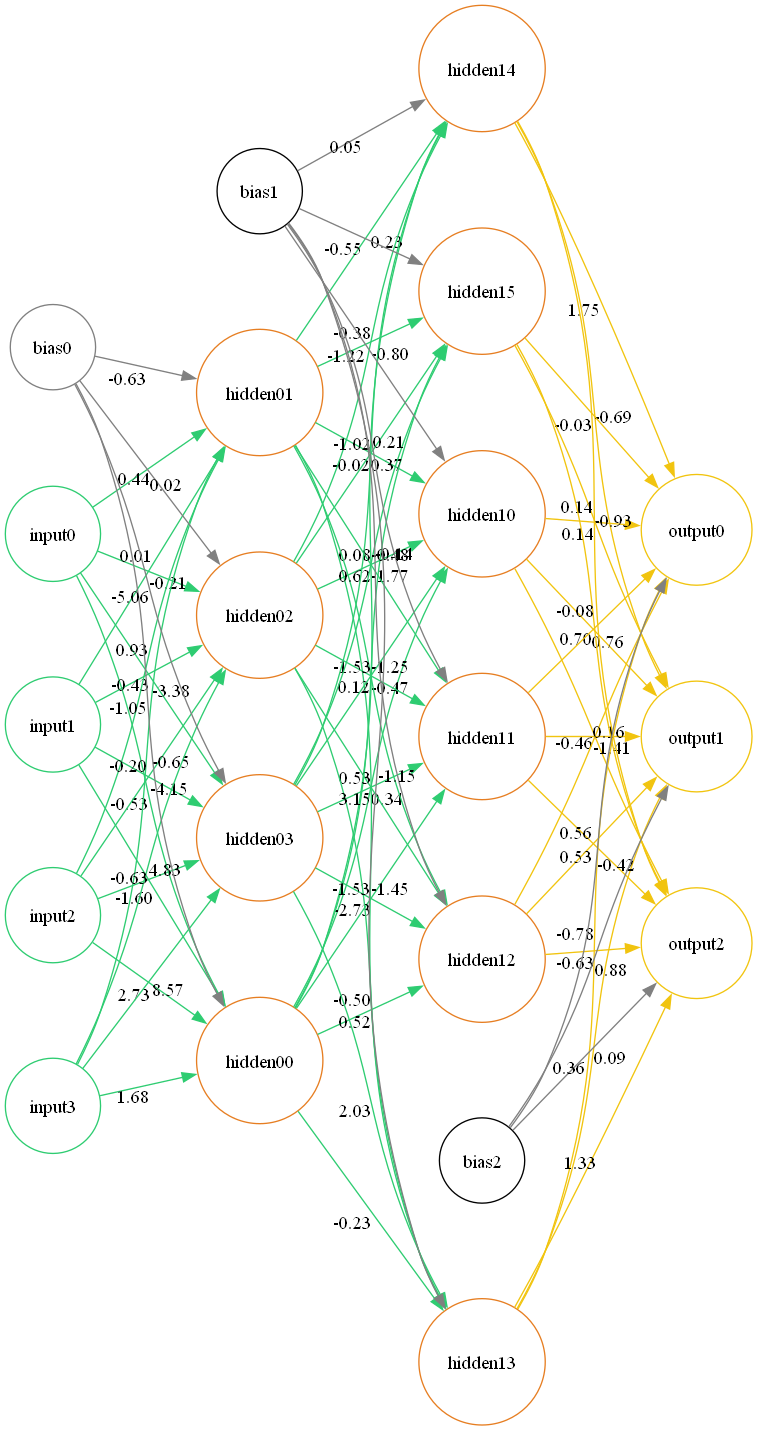

In [21]:
# Melakukan visualisasi model struktur jaringan
model.visualize()

# Mengambil gambar hasil visualisasi model untuk ditampilkan
image_path = "output/ffnn_graph.png"
display(Image(filename=image_path))

### Hasil Model

In [22]:
# Melakukan prediksi dan melihat hasil prediksi
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.93      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



### Simpan dan Muat Ulang Model

In [23]:
# Menyimpan model yang telah dibuat
model.save("iris_model")

In [24]:
# Muat ulang model yang telah disimpan
modelFactory = ModelFactory()
modelLoad = modelFactory.load("iris_model")

In [25]:
# Melakukan prediksi ulang dan melihat hasil prediksi
y_pred_load = modelLoad.predict(X_val)
print(classification_report(y_val, y_pred_load))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.93      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

